<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. 

Se utilizará como dataset los tweets sobre ChatGPT que van de Enero a Marzo de 2023 para generar los embeddings. Los vectores tendrán la forma en función de como los usuarios hayan utilizado las palabras en sus tweets sobre ChatGPT.

Fuente: https://www.kaggle.com/datasets/khalidryder777/500k-chatgpt-tweets-jan-mar-2023

### Consignas

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

In [1]:
# ! pip install gensim

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import multiprocessing
from gensim.models import Word2Vec

### Datos

In [4]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('tweets-jan-mar.csv', nrows=50000)

df = df['content']
df = df.fillna('')
df.head()

0    Free AI marketing and automation tools, strate...
1             @MecoleHardman4 Chat GPT says it’s 15. 😂
2    https://t.co/FjJSprt0te - Chat with any PDF!\n...
3    AI muses: "In the court of life, we must all f...
4    Most people haven't heard of Chat GPT yet.\nFi...
Name: content, dtype: object

In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 50000


### 1 - Preprocesamiento

In [6]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].to_frame().iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [7]:
# Demos un vistazo
sentence_tokens[:2]

[['free',
  'ai',
  'marketing',
  'and',
  'automation',
  'tools',
  'strategies',
  'and',
  'collaboration',
  'launching',
  'new',
  'week',
  'https',
  't',
  'co',
  'qwti8lfbpb',
  'chatgpt'],
 ['mecolehardman4', 'chat', 'gpt', 'says', 'it’s', '15', '😂']]

### 2 - Crear los vectores (word2vec)

In [8]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [9]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [10]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [11]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 50000


In [12]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv))

Cantidad de words distintas en el corpus: 12547


### 3 - Entrenar el modelo generador

In [13]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 8630206.0
Loss after epoch 1: 6662314.0
Loss after epoch 2: 6316478.0
Loss after epoch 3: 6114000.0
Loss after epoch 4: 5995726.0
Loss after epoch 5: 6165832.0
Loss after epoch 6: 6015544.0
Loss after epoch 7: 5865736.0
Loss after epoch 8: 5753028.0
Loss after epoch 9: 5646580.0
Loss after epoch 10: 4302924.0
Loss after epoch 11: 1244192.0
Loss after epoch 12: 1211424.0
Loss after epoch 13: 1182408.0
Loss after epoch 14: 1146384.0
Loss after epoch 15: 1110408.0
Loss after epoch 16: 1078536.0
Loss after epoch 17: 1051728.0
Loss after epoch 18: 1023288.0
Loss after epoch 19: 1005120.0


(18978597, 27968460)

### 4 - Ensayar

Se puede observar una amplia relación con términos que contienen `ai` o `chatgpt` lo cual parecen ser hashtags y tiene sentido que se relacione más con esos porque tienden a tener un patrón más repetitivo y constante entre todos los tweets.

In [44]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["chatgpt"], topn=20)

[('chatseks', 0.5559192895889282),
 ('chatgpttips', 0.5432297587394714),
 ('qrrlawtahq', 0.5397505164146423),
 ('apiplugins', 0.5388360619544983),
 ('aifun', 0.5370955467224121),
 ('chatgptで自然言語処理は終わるのか', 0.5364270806312561),
 ('chatgpthistory', 0.5348231196403503),
 ('aidevelopment', 0.5343958139419556),
 ('artificialintelliegence', 0.5299673080444336),
 ('aiml', 0.5224437117576599),
 ('aistory', 0.5204507112503052),
 ('mashable', 0.5199013352394104),
 ('gpt4api', 0.5186032056808472),
 ('aigirls', 0.5145024657249451),
 ('aiintegration', 0.5134172439575195),
 ('futureofai', 0.5109358429908752),
 ('aichatgpt', 0.5102940201759338),
 ('aiassistance', 0.5063930153846741),
 ('gpt4ai', 0.5061375498771667),
 ('aiphoto', 0.5046650171279907)]

`speed` parece estar más relacionado con `wind`, `km`, `humidity` y algunos números que pueden ser velocidades. Lo cual tiene sentido porque se habla más del clima para esta palabra.

In [50]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(positive=["speed"], topn=5)

[('wind', 0.5097934007644653),
 ('km', 0.5032691955566406),
 ('humidity', 0.45694801211357117),
 ('504', 0.4532863199710846),
 ('544', 0.451589971780777)]

Aca podemos observar los terminos menos relacionados con la palabra `speed`, lo cual parece tener sentido

In [43]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["speed"], topn=5)

[('japan', 0.04537958651781082),
 ('aware', 0.03814034163951874),
 ('writers', 0.03685425966978073),
 ('friends', 0.030309956520795822),
 ('korean', 0.02764664590358734)]

Para un conjunto de palabras, white collar jobs parece estar más relacionado a términos como `underpaid`, `300mn` (la estimación de puestos de trabajo en riesgo con ChatGPT), `greenhouse` (menos empleos de este tipo traería menos conmutación hacia las oficinas, por lo tanto menos contaminación), `salaries`

In [40]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["white", "collar", "jobs"], topn=10)

[('underpaid', 0.6077852249145508),
 ('greenhouse', 0.5809414386749268),
 ('300mn', 0.571147084236145),
 ('salaries', 0.55662602186203),
 ('occupations', 0.5488776564598083),
 ('undergraduate', 0.5418506860733032),
 ('🇪🇺', 0.5381378531455994),
 ('icims', 0.5370402336120605),
 ('recruiting', 0.5340006947517395),
 ('thirds', 0.5262135863304138)]

Hablando de beneficios, aca podemos observar que la palabra `automate` se relaciona más con `delegate` y `streamline` que son términos muy comunes cuando se habla de ChatGPT.

In [32]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["automate"], topn=5)

[('delegate', 0.5287847518920898),
 ('streamline', 0.5150728821754456),
 ('personalize', 0.5128810405731201),
 ('simplify', 0.4986609220504761),
 ('tailor', 0.48611804842948914)]

Para una palabra inexistente el código falla

In [19]:
# Ensayar con una palabra que no está en el vocabulario:
w2v_model.wv.most_similar(negative=["diedaa"])

KeyError: "Key 'diedaa' not present in vocabulary"

### 5 - Visualizar agrupación de vectores

In [45]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [46]:
# ! pip install plotly
# ! pip install --upgrade nbformat

In [47]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show()

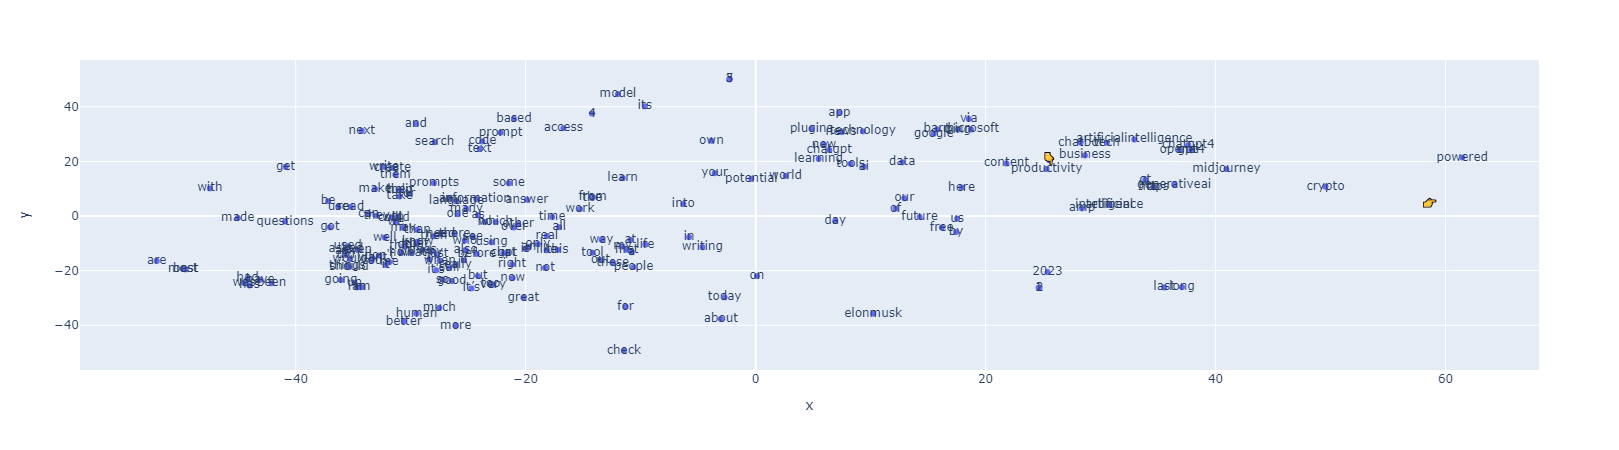

In [1]:
# Agrego esto porque plotly no deja el grafico despues de ejecutar en el repositorio
from IPython.display import Image

# Mostrar plot.png
Image(filename='plot.png')

## Conclusiones

### De la gráfica de los embeddings
- Vemos que las palabras más comunes del idioma inglés están agrupadas a la izquierda y terminología más especifica a ChatGPT a la derecha.
- El término `chatgpt`, central en este dataset, aparece más cerca del origen de coordenadas junto con otros términos muy comunes en general al tema de ChatGPT, como `potential`, `world`, `writing`.
- También podemos observar que hay pequeños grupos de palabras que están relacionadas entre sí, como por ejemplo `prompt`, `based`, `text`, `code`; `has`, `had`, `was`, `have`, `been`; `content`, `productivity`, `👇` (Este emoji es muy utilizado tweets hablan sobre como mejorar tu productividad por ejemplo, invitando a seguir leyendo la cadena de respuestas del autor).
- También se pueden observar pares de palabras que se relacionan con frecuencia, como `google` con `bard`; `microsoft` con `bing`; `openai` con `gpt4`; `artificial` con `intelligence`.

### Del trabajo en general
- El dataset completo son 500 mil muestras, se tomó solo 50 mil y solo se entrenó por 20 epochs porque sino se hubiese demorado mucho más.
- Se podría aplicar un preprocessing más exhaustivo, como por ejemplo eliminar los emojis, los hashtags, los links, etc.
- Estos embeddings se podrían utilizar para analizar la similitud entre tweets, por ejemplo, para agruparlos en clusters y generar recomendaciones de tweets similares a los que le gustan a un usuario sobre esta temática.